In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_moons, make_s_curve

from Autoencoders import ScaledIsometricAutoencoder, ConformalAutoencoder, IsometricAutoencoder
from helper import load_optimizer_and_scheduler, save_optimizer_and_scheduler
from data import make_half_sphere
from metrics import evaluate_conformality, scaled_isometry_jacobian_loss

random_state = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, z):
        return self.fc(z)

In [3]:
data, labels = make_half_sphere(n_samples=3000, noise=0.05, random_state=random_state)
data = torch.tensor(data, dtype=torch.float32).to(device)
val_data, val_labels = make_half_sphere(n_samples=1000, noise=0.05, random_state=random_state+1)
val_data = torch.tensor(val_data, dtype=torch.float32).to(device)

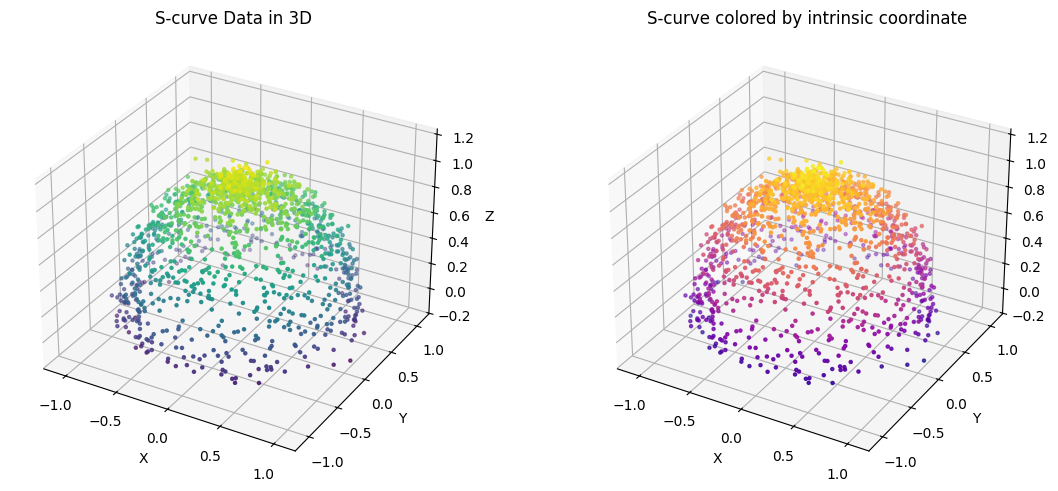

In [4]:
# Visualize the S-curve data
fig = plt.figure(figsize=(12, 5))

# 3D view
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(data[:, 0].cpu(), data[:, 1].cpu(), data[:, 2].cpu(), c=labels, s=5, cmap='viridis')
ax1.set_title("S-curve Data in 3D")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Color by intrinsic coordinate
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(data[:, 0].cpu(), data[:, 1].cpu(), data[:, 2].cpu(), c=labels, s=5, cmap='plasma')
ax2.set_title("S-curve colored by intrinsic coordinate")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [5]:
# Define model parameters
latent_dim = 2
input_dim = data.shape[1]  # 3 for S-curve
output_dim = data.shape[1]
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

dir_path = "models/conformal_autoencoder_cosine_comp_halfsphere2"

In [6]:
# lambda_isos = np.logspace(0, 2.5, 9)
# lambda_isos = np.concat([np.zeros(1), lambda_isos])

In [7]:
# Lambda values for comparison
lambda_isos = np.logspace(-3, 2, 9)
lambda_isos = np.concatenate([np.zeros(1), lambda_isos])

In [8]:
# Using scaled isometry loss (no specific import needed, it's in the autoencoder)

In [9]:
import os

def modelpath(dir_path, lambda_iso, index):
    os.makedirs(dir_path, exist_ok=True)
    return f"{dir_path}/lambda_{lambda_iso:.3f}_model_{index+1}.pth"

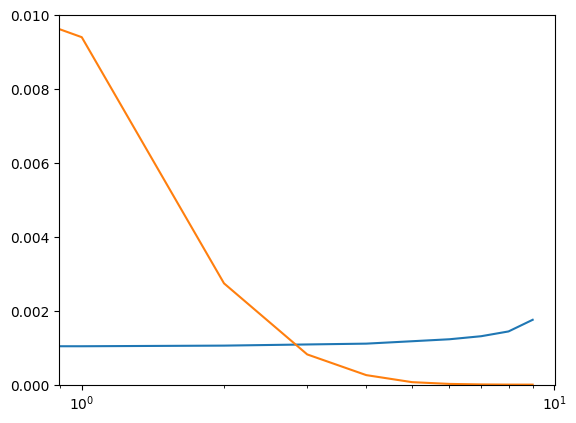

In [165]:
# read results
results_df = pd.read_csv(f"{dir_path}/results.csv")

plt.plot(results_df["reconstruction_error"])
plt.plot(results_df["conformality_metric"])
plt.ylim(0, 0.01)
plt.xscale("log")

In [172]:
results_df2 = pd.read_csv(f"{dir_path}/results.csv")

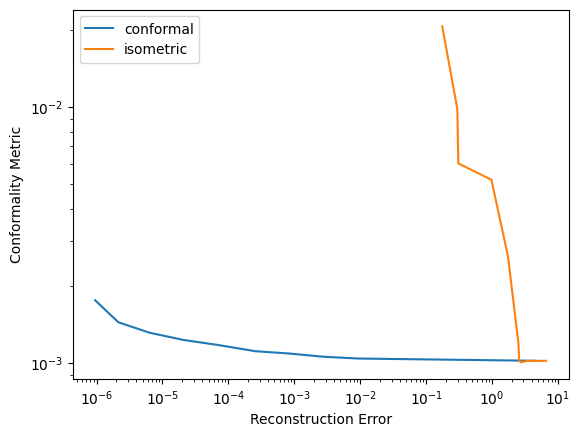

In [179]:
# read results
#results_df = pd.read_csv(f"{dir_path}/results.csv")

plt.plot(results_df["conformality_metric"],results_df["reconstruction_error"],  label="conformal")
plt.plot(results_df2["conformality_metric"], results_df2["reconstruction_error"], label="isometric")
# plt.plot(results_df["conformality_metric"])
#plt.ylim(0, 0.01)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("Reconstruction Error")
plt.ylabel("Conformality Metric")
plt.show()

In [64]:
print(model_path)
checkpoint = torch.load(model_path)
print(checkpoint.keys())

models/isometric_autoencoder_comp_scurve/lambda_100.000_model_4.pth
dict_keys(['epochs_trained', 'model_state_dict', 'loss_list', 'val_loss_list', 'metrics_list', 'val_metrics_list'])


In [10]:
dir_path = "models/conformal_autoencoder_jacobian_comp_halfsphere"
statses1 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 0)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses1.append(evaluate_conformality(model, data))
df_1 = pd.DataFrame(statses1, index=lambda_isos)

statses2 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 1)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses2.append(evaluate_conformality(model, data))
df_2 = pd.DataFrame(statses2, index=lambda_isos)

statses3 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 2)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses3.append(evaluate_conformality(model, data))
df_3 = pd.DataFrame(statses3, index=lambda_isos)

statses4 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 3)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses4.append(evaluate_conformality(model, data))
df_4 = pd.DataFrame(statses4, index=lambda_isos)

df_concat = pd.concat([df_1, df_2, df_3, df_4])
by_row_index = df_concat.groupby(df_concat.index)
df3 = by_row_index.mean()
df3_std = by_row_index.std()

/home/maxheise/anaconda3/envs/ML/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [11]:
df3 = df3[["reconstruction_error", "jTj_minus_lambdaI_norm", "jTj_minus_lambdaI_norm_normed", "diagonal_gini", "lambda_mean", "latent_norm",  "determinant_vs_estimate_mean"]]

In [12]:

df3.rename(columns={
    "reconstruction_error": "Recon MSE",
    "jTj_minus_lambdaI_norm": "Conformality Metric",
    "jTj_minus_lambdaI_norm_normed": "Conf Metric Normalized",
    "diagonal_gini": "Diagonal Uniformity (Gini)",
    "lambda_mean": "Mean Conformal Factor",
    "latent_norm": "Latent Norm",
    "determinant_vs_estimate_mean": "Determinant estimate acc"
}, inplace=True)

In [13]:
df3 = df3[["Recon MSE", "Conformality Metric", "Mean Conformal Factor", "Latent Norm", "Conf Metric Normalized", "Diagonal Uniformity (Gini)", "Determinant estimate acc", ]]

In [14]:
styled_df = df3.style \
    .background_gradient(subset=[
            "Recon MSE",
            "Diagonal Uniformity (Gini)",
            # 'lambda_std',
            # 'lambda_std_normed',
            # 'off_diag_mean',
            # 'off_diag_norm',
            # 'off_diag_mean_normed',
            # 'off_diag_norm_normed',
            # 'jTj_minus_lambdaI_mean',
            "Conformality Metric",
            # 'jTj_minus_lambdaI_mean_normed',
            "Conf Metric Normalized",
            # 'determinant_vs_estimate_std',
            ], cmap='Reds') \
    .background_gradient(subset=[
        "Determinant estimate acc"
    ], cmap='Greens')\
    .background_gradient(subset=[
        "Mean Conformal Factor",
        # 'latent_std',
        # 'latent_std_max',
        # 'latent_std_min',
        "Latent Norm",
    ], cmap='Blues')

styled_df

In [15]:
import dataframe_image as dfi

dfi.export(styled_df, "comparison_table_halfsphere.png")

Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.

In [14]:
dir_path = "models/conformal_autoencoder_jacobian_comp_halfsphere"
statses1 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 0)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses1.append(evaluate_conformality(model, data))
df_1 = pd.DataFrame(statses1, index=lambda_isos)

statses2 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 1)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses2.append(evaluate_conformality(model, data))
df_2 = pd.DataFrame(statses2, index=lambda_isos)

statses3 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 2)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses3.append(evaluate_conformality(model, data))
df_3 = pd.DataFrame(statses3, index=lambda_isos)

statses4 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 3)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses4.append(evaluate_conformality(model, data))
df_4 = pd.DataFrame(statses4, index=lambda_isos)

df_concat = pd.concat([df_1, df_2, df_3, df_4])
by_row_index = df_concat.groupby(df_concat.index)
df4 = by_row_index.mean()
df4_std = by_row_index.std()

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
styled_df = 

In [ ]:
styled_df["reconstruction_error", "jTj_minus_lambdaI_norm", "jTj_minus_lambdaI_norm_normed", "lambda_mean", "diagonal_gini", "latent_norm"]

TypeError: 'Styler' object is not subscriptable

In [ ]:
"reconstruction_error", "jTj_minus_lambdaI_norm_normed", "lambda_mean", "diagonal_gini", "latent_norm", "determinant_vs_estimate_mean"

In [109]:
styled_df = df3.style \
    .background_gradient(subset=[
            'reconstruction_error',
            'diagonal_gini',
            'lambda_std',
            'lambda_std_normed',
            'off_diag_mean',
            'off_diag_norm',
            'off_diag_mean_normed',
            'off_diag_norm_normed',
            'jTj_minus_lambdaI_mean',
            'jTj_minus_lambdaI_norm',
            'jTj_minus_lambdaI_mean_normed',
            'jTj_minus_lambdaI_norm_normed',
            'determinant_vs_estimate_std',
            ], cmap='Reds') \
    .background_gradient(subset=[
        'determinant_vs_estimate_mean'
    ], cmap='Greens')\
    .background_gradient(subset=[
        'lambda_mean',
        'latent_std',
        'latent_std_max',
        'latent_std_min',
        'latent_norm',
    ], cmap='Blues')

styled_df

In [59]:
# Lambda values for comparison
lambda_isos = np.logspace(-3, 2, 9)
lambda_isos = np.concatenate([np.zeros(1), lambda_isos])

In [11]:
dir_path = "models/isometric_autoencoder_comp_halfsphere"
statses1 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 0)
    model = ScaledIsometricAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_iso=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses1.append(evaluate_conformality(model, data))
df_1 = pd.DataFrame(statses1, index=lambda_isos)

statses2 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 1)
    model = ScaledIsometricAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_iso=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses2.append(evaluate_conformality(model, data))
df_2 = pd.DataFrame(statses2, index=lambda_isos)

statses3 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 2)
    model = ScaledIsometricAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_iso=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses3.append(evaluate_conformality(model, data))
df_3 = pd.DataFrame(statses3, index=lambda_isos)

statses4 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 3)
    model = ScaledIsometricAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_iso=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses4.append(evaluate_conformality(model, data))
df_4 = pd.DataFrame(statses4, index=lambda_isos)

df_concat = pd.concat([df_1, df_2, df_3, df_4])
by_row_index = df_concat.groupby(df_concat.index)
df1 = by_row_index.mean()
df1_std = by_row_index.std()

/home/maxheise/anaconda3/envs/ML/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [56]:
# Lambda values for comparison
lambda_isos = np.logspace(-2, 3, 9)
lambda_isos = np.concatenate([np.zeros(1), lambda_isos])
lambda_isos = np.logspace(2, 3, 7)
lambda_isos = np.concat([np.zeros(1), lambda_isos])

In [67]:
dir_path = "models/conformal_autoencoder_cosine_comp_halfsphere_train2"
statses1 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 0)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    # model.load_state_dict(torch.load(model_path))
    model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses1.append(evaluate_conformality(model, data))
df_1 = pd.DataFrame(statses1, index=lambda_isos)

statses2 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 1)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    # model.load_state_dict(torch.load(model_path))
    model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses2.append(evaluate_conformality(model, data))
df_2 = pd.DataFrame(statses2, index=lambda_isos)

statses3 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 2)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    # model.load_state_dict(torch.load(model_path))
    model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses3.append(evaluate_conformality(model, data))
df_3 = pd.DataFrame(statses3, index=lambda_isos)

statses4 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 3)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    # model.load_state_dict(torch.load(model_path))
    model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses4.append(evaluate_conformality(model, data))
df_4 = pd.DataFrame(statses4, index=lambda_isos)

df_concat = pd.concat([df_1, df_2, df_3, df_4])
by_row_index = df_concat.groupby(df_concat.index)
df3 = by_row_index.mean()
df3_std = by_row_index.std()

Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere_train2/lambda_0.000_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere_train2/lambda_0.001_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere_train2/lambda_0.004_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere_train2/lambda_0.018_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere_train2/lambda_0.075_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere_train2/lambda_0.316_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere_train2/lambda_1.334_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere_train2/lambda_5.623_model_1.pth
Model and custom

In [72]:
dir_path = "models/conformal_autoencoder_cosine_comp_halfsphere"
statses1 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 0)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses1.append(evaluate_conformality(model, data))
df_1 = pd.DataFrame(statses1, index=lambda_isos)

statses2 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 1)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses2.append(evaluate_conformality(model, data))
df_2 = pd.DataFrame(statses2, index=lambda_isos)

statses3 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 2)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses3.append(evaluate_conformality(model, data))
df_3 = pd.DataFrame(statses3, index=lambda_isos)

statses4 = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 3)
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    # model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses4.append(evaluate_conformality(model, data))
df_4 = pd.DataFrame(statses4, index=lambda_isos)

df_concat = pd.concat([df_1, df_2, df_3, df_4])
by_row_index = df_concat.groupby(df_concat.index)
df2 = by_row_index.mean()
df2_std = by_row_index.std()

In [75]:
df_concat = pd.concat([df2, df3])
by_row_index = df_concat.groupby(df_concat.index)
df4 = by_row_index.mean()
df4_std = by_row_index.std()

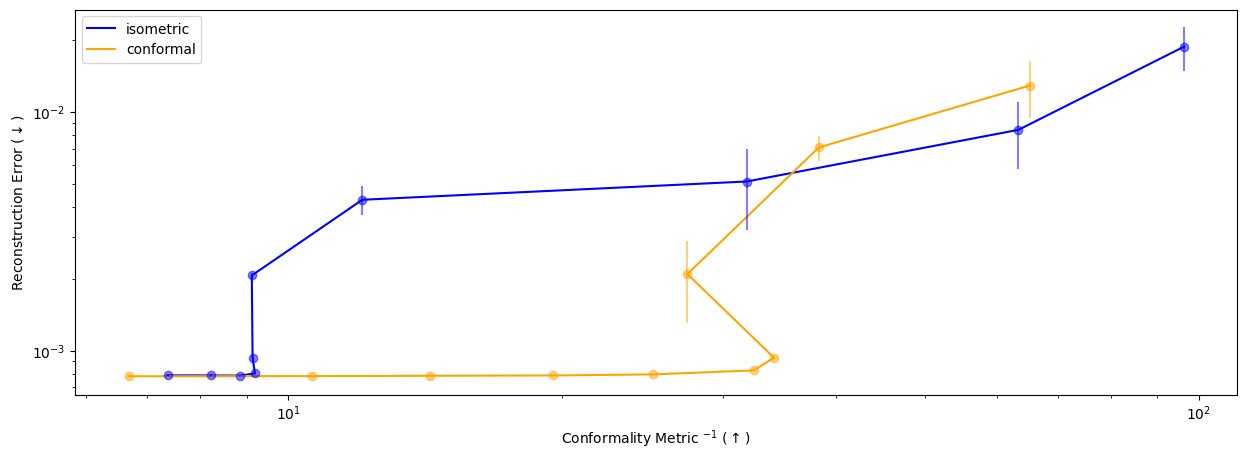

In [96]:
plt.figure(figsize=(15, 5))
plt.plot(1/df1["jTj_minus_lambdaI_mean_normed"], df1["reconstruction_error"], label="isometric", c="blue")
plt.plot(1/df2["jTj_minus_lambdaI_mean_normed"], df2["reconstruction_error"], label="conformal", c="orange")
plt.legend()
plt.errorbar(1/df1["jTj_minus_lambdaI_mean_normed"], df1["reconstruction_error"], xerr=df1_std["jTj_minus_lambdaI_mean_normed"], yerr=df1_std["reconstruction_error"], fmt='o', label='isometric', alpha=0.5, c="blue")
plt.errorbar(1/df2["jTj_minus_lambdaI_mean_normed"], df2["reconstruction_error"], xerr=df2_std["jTj_minus_lambdaI_mean_normed"], yerr=df2_std["reconstruction_error"], fmt='o', label='conformal', alpha=0.5, c="orange")

plt.xscale("log")
plt.yscale("log")

plt.ylabel(r"Reconstruction Error $(\downarrow)$")
plt.xlabel(r"Conformality Metric $^{-1}$ $(\uparrow)$")
# plt.xlabel(r'$\frac{1}{Conformality Metric}$')
plt.show()

In [245]:
df1["jTj_minus_lambdaI_mean_normed"]

0.000000      0.135634
0.001000      0.121709
0.004217      0.113048
0.017783      0.108804
0.074989      0.109450
0.316228      0.109666
1.333521      0.082926
5.623413      0.031367
23.713737     0.015778
100.000000    0.010374
Name: jTj_minus_lambdaI_mean_normed, dtype: float64

In [246]:
1/df1["jTj_minus_lambdaI_mean_normed"]

0.000000       7.372759
0.001000       8.216308
0.004217       8.845771
0.017783       9.190815
0.074989       9.136623
0.316228       9.118569
1.333521      12.058886
5.623413      31.880263
23.713737     63.379865
100.000000    96.396025
Name: jTj_minus_lambdaI_mean_normed, dtype: float64

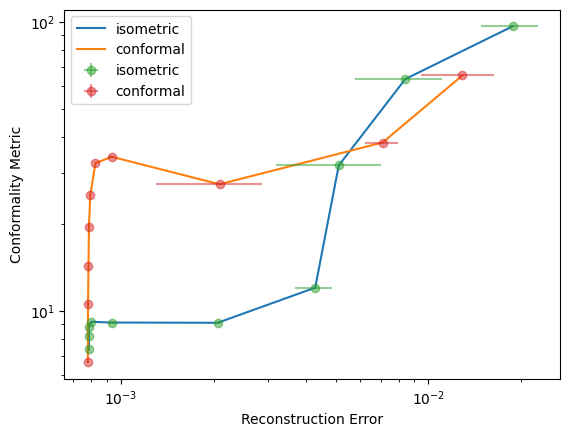

In [250]:
plt.plot(df1["reconstruction_error"], 1/df1["jTj_minus_lambdaI_mean_normed"], label="isometric")
plt.plot(df2["reconstruction_error"], 1/df2["jTj_minus_lambdaI_mean_normed"], label="conformal")

plt.errorbar(df1["reconstruction_error"], 1/df1["jTj_minus_lambdaI_mean_normed"], xerr=df1_std["reconstruction_error"], yerr=df1_std["jTj_minus_lambdaI_mean_normed"], fmt='o', label='isometric', alpha=0.5)
plt.errorbar(df2["reconstruction_error"], 1/df2["jTj_minus_lambdaI_mean_normed"], xerr=df2_std["reconstruction_error"], yerr=df2_std["jTj_minus_lambdaI_mean_normed"], fmt='o', label='conformal', alpha=0.5)

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("Reconstruction Error")
plt.ylabel("Conformality Metric")
plt.show()

In [222]:
styled_df = df2.style \
    .background_gradient(subset=[
            'reconstruction_error',
            'diagonal_gini',
            'lambda_std',
            'lambda_std_normed',
            'off_diag_mean',
            'off_diag_norm',
            'off_diag_mean_normed',
            'off_diag_norm_normed',
            'jTj_minus_lambdaI_mean',
            'jTj_minus_lambdaI_norm',
            'jTj_minus_lambdaI_mean_normed',
            'jTj_minus_lambdaI_norm_normed',
            'determinant_vs_estimate_std',
            ], cmap='Reds') \
    .background_gradient(subset=[
        'determinant_vs_estimate_mean'
    ], cmap='Greens')\
    .background_gradient(subset=[
        'lambda_mean',
        'latent_std',
        'latent_std_max',
        'latent_std_min',
        'latent_norm',
    ], cmap='Blues')

styled_df

In [219]:
styled_df = df1.style \
    .background_gradient(subset=[
            'reconstruction_error',
            'diagonal_gini',
            'lambda_std',
            'lambda_std_normed',
            'off_diag_mean',
            'off_diag_norm',
            'off_diag_mean_normed',
            'off_diag_norm_normed',
            'jTj_minus_lambdaI_mean',
            'jTj_minus_lambdaI_norm',
            'jTj_minus_lambdaI_mean_normed',
            'jTj_minus_lambdaI_norm_normed',
            'determinant_vs_estimate_std',
            ], cmap='Reds') \
    .background_gradient(subset=[
        'determinant_vs_estimate_mean'
    ], cmap='Greens')\
    .background_gradient(subset=[
        'lambda_mean',
        'latent_std',
        'latent_std_max',
        'latent_std_min',
        'latent_norm',
    ], cmap='Blues')

styled_df

Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_0.000_model_4.pth
Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_0.010_model_4.pth
Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_0.042_model_3.pth
Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_0.178_model_3.pth


Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_0.750_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_3.162_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_13.335_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_56.234_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_237.137_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_jacobian_comp_halfsphere2/lambda_1000.000_model_4.pth


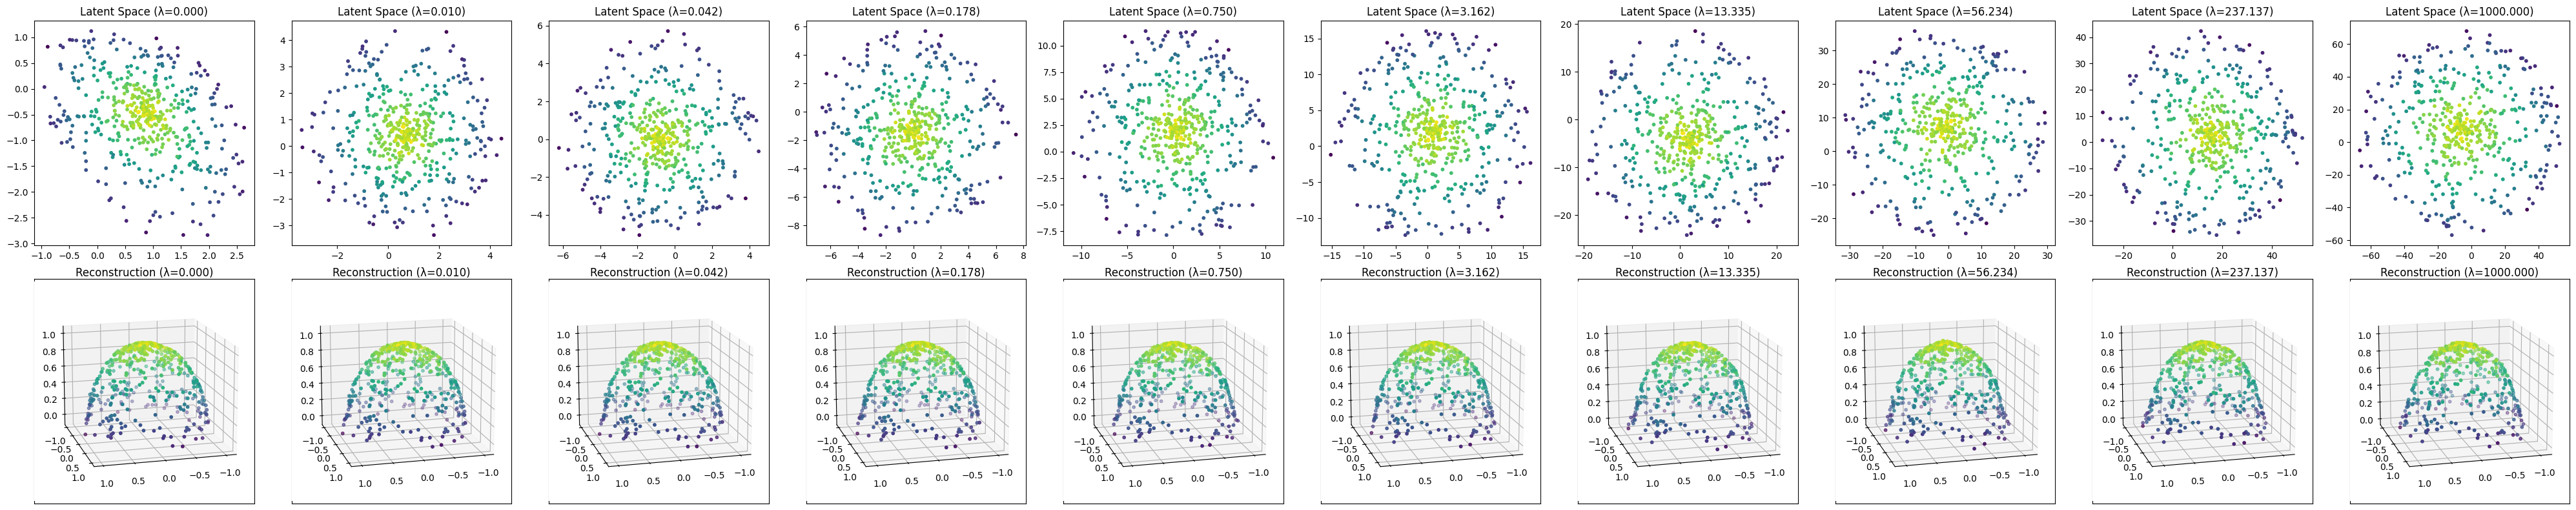

In [154]:
indeces = [3,3,2,2,1,1,1,1,1,3] #isometry

# Visualize latent representations and reconstructions
fig, axs = plt.subplots(2, min(10, len(lambda_isos)), figsize=(4*min(10, len(lambda_isos)), 8))
if len(lambda_isos) == 1:
    axs = axs.reshape(2, 1)

for i, lambda_iso in enumerate(lambda_isos[:10]):  # Limit to 10 for visibility
    # Load a trained model
    model_path = modelpath(dir_path, lambda_iso, indeces[i])  # Use first model
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ScaledIsometricAutoencoder(encoder, decoder, lambda_iso=lambda_iso).to(device)
    model.load_model_from_checkpoint(model_path)
    # model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    # Plot latent space (2D)
    axs[0, i].scatter(encoded_data[:, 0].cpu(), encoded_data[:, 1].cpu(), 
                     c=val_labels, s=10, cmap='viridis')
    axs[0, i].set_title(f'Latent Space (λ={lambda_iso:.3f})')
    
    # Create 3D subplot for reconstruction
    ax_3d = fig.add_subplot(2, min(10, len(lambda_isos)), min(10, len(lambda_isos)) + i + 1, projection='3d')
    ax_3d.scatter(reconstruction[:, 0].cpu(), reconstruction[:, 1].cpu(), reconstruction[:, 2].cpu(), 
                 c=val_labels, s=10, cmap='viridis')
    ax_3d.set_title(f'Reconstruction (λ={lambda_iso:.3f})')

    # remove axis for 3D plot
    # ax_3d.set_xticks([])
    # ax_3d.set_yticks([])
    # ax_3d.set_zticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

    # change 3d plot angle
    ax_3d.view_init(elev=15, azim=75, roll=0)

plt.tight_layout()
plt.show()

Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_0.000_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_1.000_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_2.054_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_4.217_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_8.660_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_17.783_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_36.517_model_1.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_74.989_model_1.pth
Model and custom variables loaded from models/conformal_autoe

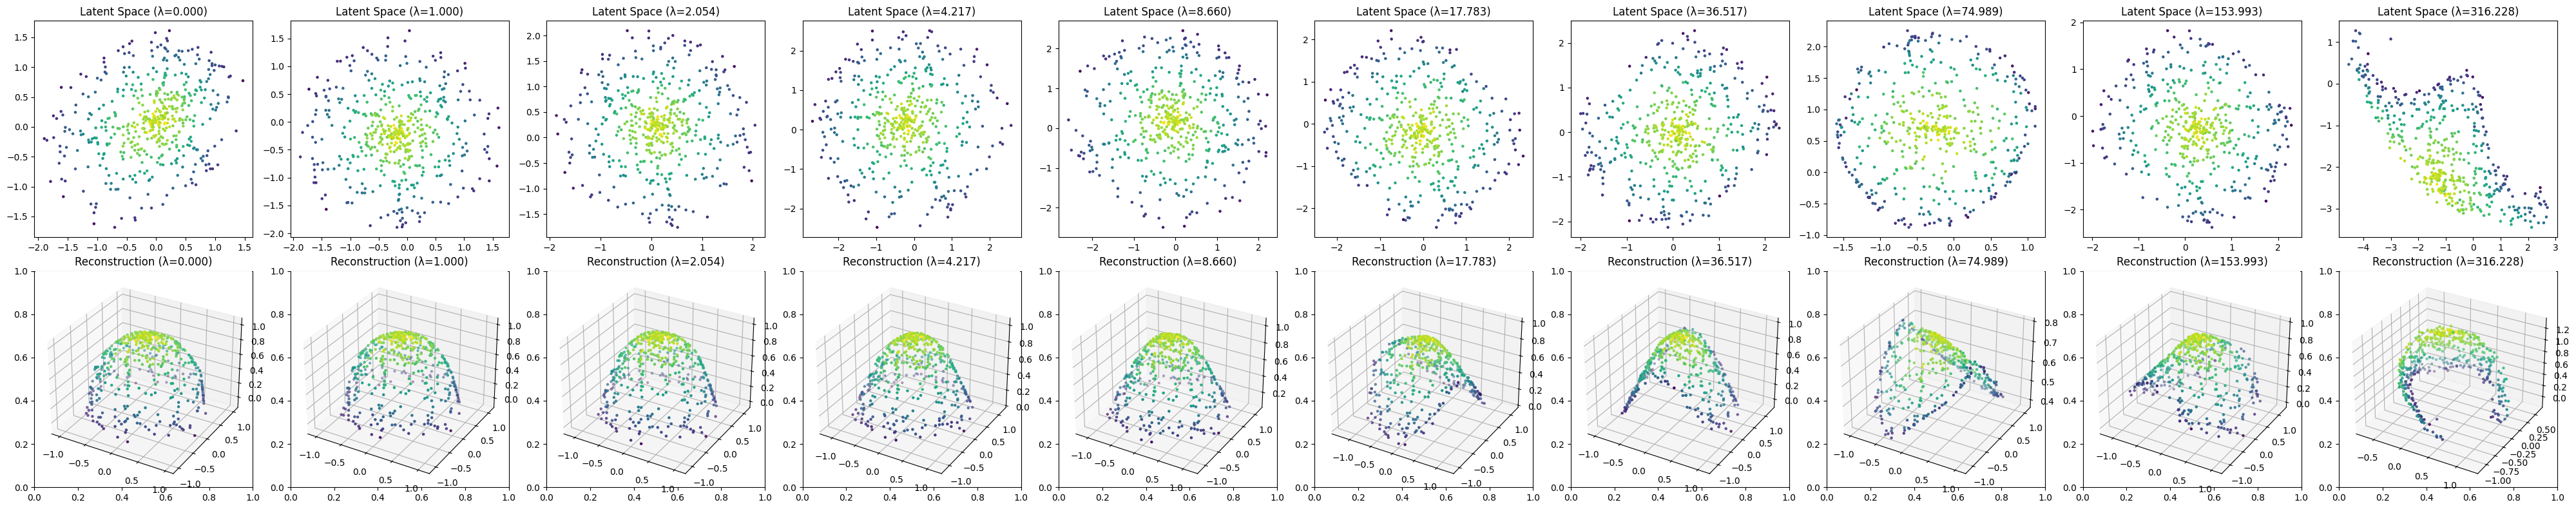

In [100]:
indeces = [0,0,0,0,0,0,0,0,0,0]

# Visualize latent representations and reconstructions
fig, axs = plt.subplots(2, min(10, len(lambda_isos)), figsize=(4*min(10, len(lambda_isos)), 8))
if len(lambda_isos) == 1:
    axs = axs.reshape(2, 1)

for i, lambda_iso in enumerate(lambda_isos[:10]):  # Limit to 10 for visibility
    # Load a trained model
    model_path = modelpath(dir_path, lambda_iso, 0)  # Use first model
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ScaledIsometricAutoencoder(encoder, decoder, lambda_iso=lambda_iso).to(device)
    model.load_model_from_checkpoint(model_path)
    # model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    # Plot latent space (2D)
    axs[0, i].scatter(encoded_data[:, 0].cpu(), encoded_data[:, 1].cpu(), 
                     c=val_labels, s=5, cmap='viridis')
    axs[0, i].set_title(f'Latent Space (λ={lambda_iso:.3f})')
    
    # Create 3D subplot for reconstruction
    ax_3d = fig.add_subplot(2, min(10, len(lambda_isos)), min(10, len(lambda_isos)) + i + 1, projection='3d')
    ax_3d.scatter(reconstruction[:, 0].cpu(), reconstruction[:, 1].cpu(), reconstruction[:, 2].cpu(), 
                 c=val_labels, s=5, cmap='viridis')
    ax_3d.set_title(f'Reconstruction (λ={lambda_iso:.3f})')

plt.tight_layout()
plt.show()

Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_0.000_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_1.000_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_2.054_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_4.217_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_8.660_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_17.783_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_36.517_model_2.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_74.989_model_2.pth
Model and custom variables loaded from models/conformal_autoe

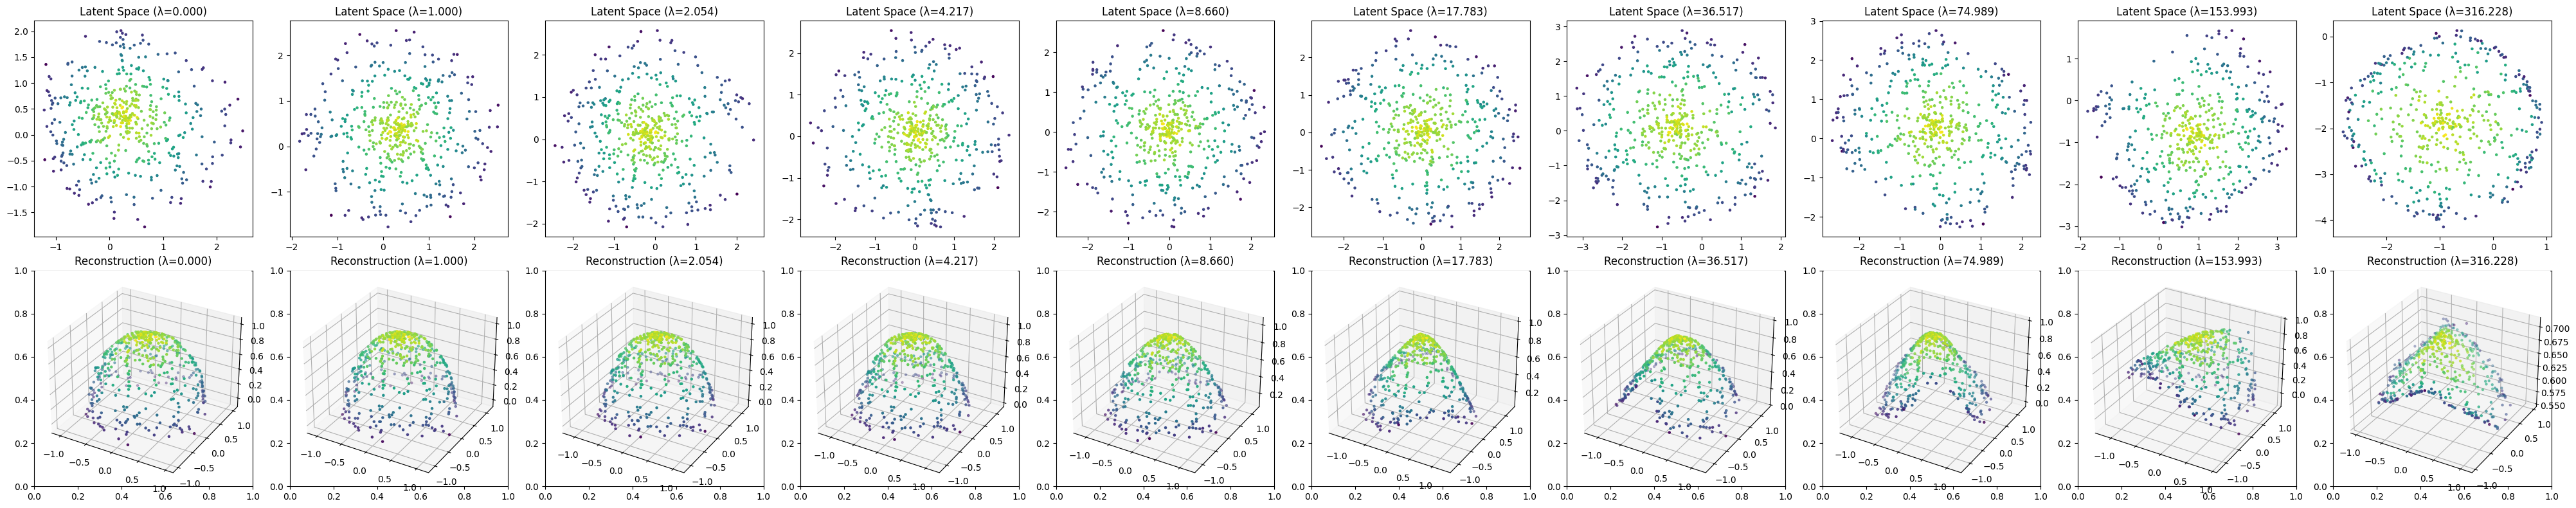

In [101]:
indeces = [0,0,0,0,0,0,0,0,0,0]

# Visualize latent representations and reconstructions
fig, axs = plt.subplots(2, min(10, len(lambda_isos)), figsize=(4*min(10, len(lambda_isos)), 8))
if len(lambda_isos) == 1:
    axs = axs.reshape(2, 1)

for i, lambda_iso in enumerate(lambda_isos[:10]):  # Limit to 10 for visibility
    # Load a trained model
    model_path = modelpath(dir_path, lambda_iso, 1)  # Use first model
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ScaledIsometricAutoencoder(encoder, decoder, lambda_iso=lambda_iso).to(device)
    model.load_model_from_checkpoint(model_path)
    # model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    # Plot latent space (2D)
    axs[0, i].scatter(encoded_data[:, 0].cpu(), encoded_data[:, 1].cpu(), 
                     c=val_labels, s=5, cmap='viridis')
    axs[0, i].set_title(f'Latent Space (λ={lambda_iso:.3f})')
    
    # Create 3D subplot for reconstruction
    ax_3d = fig.add_subplot(2, min(10, len(lambda_isos)), min(10, len(lambda_isos)) + i + 1, projection='3d')
    ax_3d.scatter(reconstruction[:, 0].cpu(), reconstruction[:, 1].cpu(), reconstruction[:, 2].cpu(), 
                 c=val_labels, s=5, cmap='viridis')
    ax_3d.set_title(f'Reconstruction (λ={lambda_iso:.3f})')

plt.tight_layout()
plt.show()

Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_0.000_model_3.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_1.000_model_3.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_2.054_model_3.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_4.217_model_3.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_8.660_model_3.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_17.783_model_3.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_36.517_model_3.pth


Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_74.989_model_3.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_153.993_model_3.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_316.228_model_3.pth


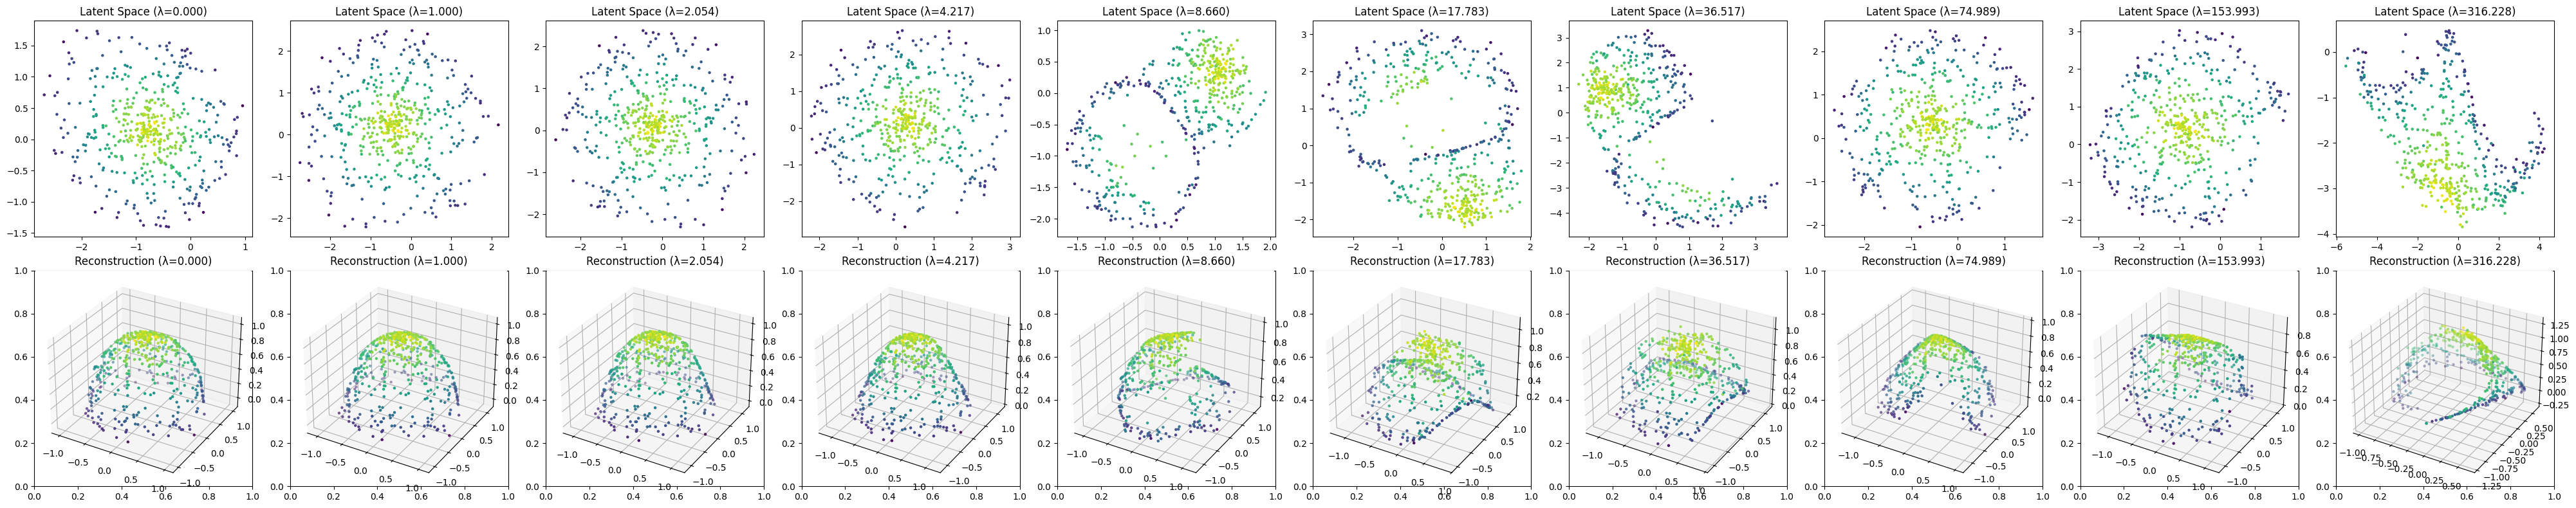

In [102]:
indeces = [0,0,0,0,0,0,0,0,0,0]

# Visualize latent representations and reconstructions
fig, axs = plt.subplots(2, min(10, len(lambda_isos)), figsize=(4*min(10, len(lambda_isos)), 8))
if len(lambda_isos) == 1:
    axs = axs.reshape(2, 1)

for i, lambda_iso in enumerate(lambda_isos[:10]):  # Limit to 10 for visibility
    # Load a trained model
    model_path = modelpath(dir_path, lambda_iso, 2)  # Use first model
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ScaledIsometricAutoencoder(encoder, decoder, lambda_iso=lambda_iso).to(device)
    model.load_model_from_checkpoint(model_path)
    # model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    # Plot latent space (2D)
    axs[0, i].scatter(encoded_data[:, 0].cpu(), encoded_data[:, 1].cpu(), 
                     c=val_labels, s=5, cmap='viridis')
    axs[0, i].set_title(f'Latent Space (λ={lambda_iso:.3f})')
    
    # Create 3D subplot for reconstruction
    ax_3d = fig.add_subplot(2, min(10, len(lambda_isos)), min(10, len(lambda_isos)) + i + 1, projection='3d')
    ax_3d.scatter(reconstruction[:, 0].cpu(), reconstruction[:, 1].cpu(), reconstruction[:, 2].cpu(), 
                 c=val_labels, s=5, cmap='viridis')
    ax_3d.set_title(f'Reconstruction (λ={lambda_iso:.3f})')

plt.tight_layout()
plt.show()

Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_0.000_model_4.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_1.000_model_4.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_2.054_model_4.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_4.217_model_4.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_8.660_model_4.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_17.783_model_4.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_36.517_model_4.pth
Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_halfsphere2/lambda_74.989_model_4.pth
Model and custom variables loaded from models/conformal_autoe

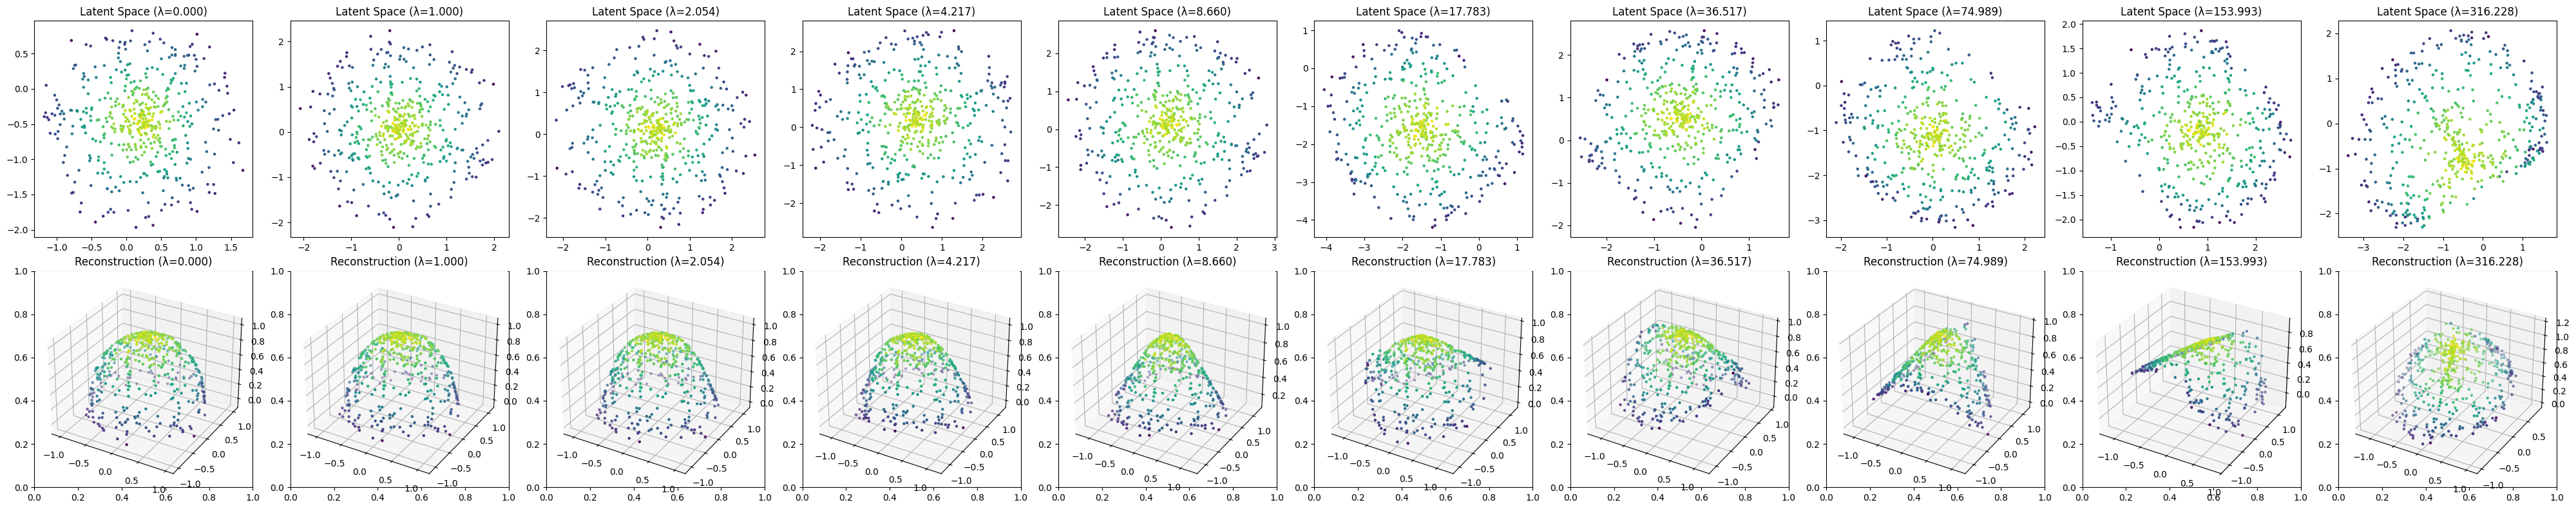

In [103]:
indeces = [0,0,0,0,0,0,0,0,0,0]

# Visualize latent representations and reconstructions
fig, axs = plt.subplots(2, min(10, len(lambda_isos)), figsize=(4*min(10, len(lambda_isos)), 8))
if len(lambda_isos) == 1:
    axs = axs.reshape(2, 1)

for i, lambda_iso in enumerate(lambda_isos[:10]):  # Limit to 10 for visibility
    # Load a trained model
    model_path = modelpath(dir_path, lambda_iso, 3)  # Use first model
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ScaledIsometricAutoencoder(encoder, decoder, lambda_iso=lambda_iso).to(device)
    model.load_model_from_checkpoint(model_path)
    # model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    # Plot latent space (2D)
    axs[0, i].scatter(encoded_data[:, 0].cpu(), encoded_data[:, 1].cpu(), 
                     c=val_labels, s=5, cmap='viridis')
    axs[0, i].set_title(f'Latent Space (λ={lambda_iso:.3f})')
    
    # Create 3D subplot for reconstruction
    ax_3d = fig.add_subplot(2, min(10, len(lambda_isos)), min(10, len(lambda_isos)) + i + 1, projection='3d')
    ax_3d.scatter(reconstruction[:, 0].cpu(), reconstruction[:, 1].cpu(), reconstruction[:, 2].cpu(), 
                 c=val_labels, s=5, cmap='viridis')
    ax_3d.set_title(f'Reconstruction (λ={lambda_iso:.3f})')

plt.tight_layout()
plt.show()

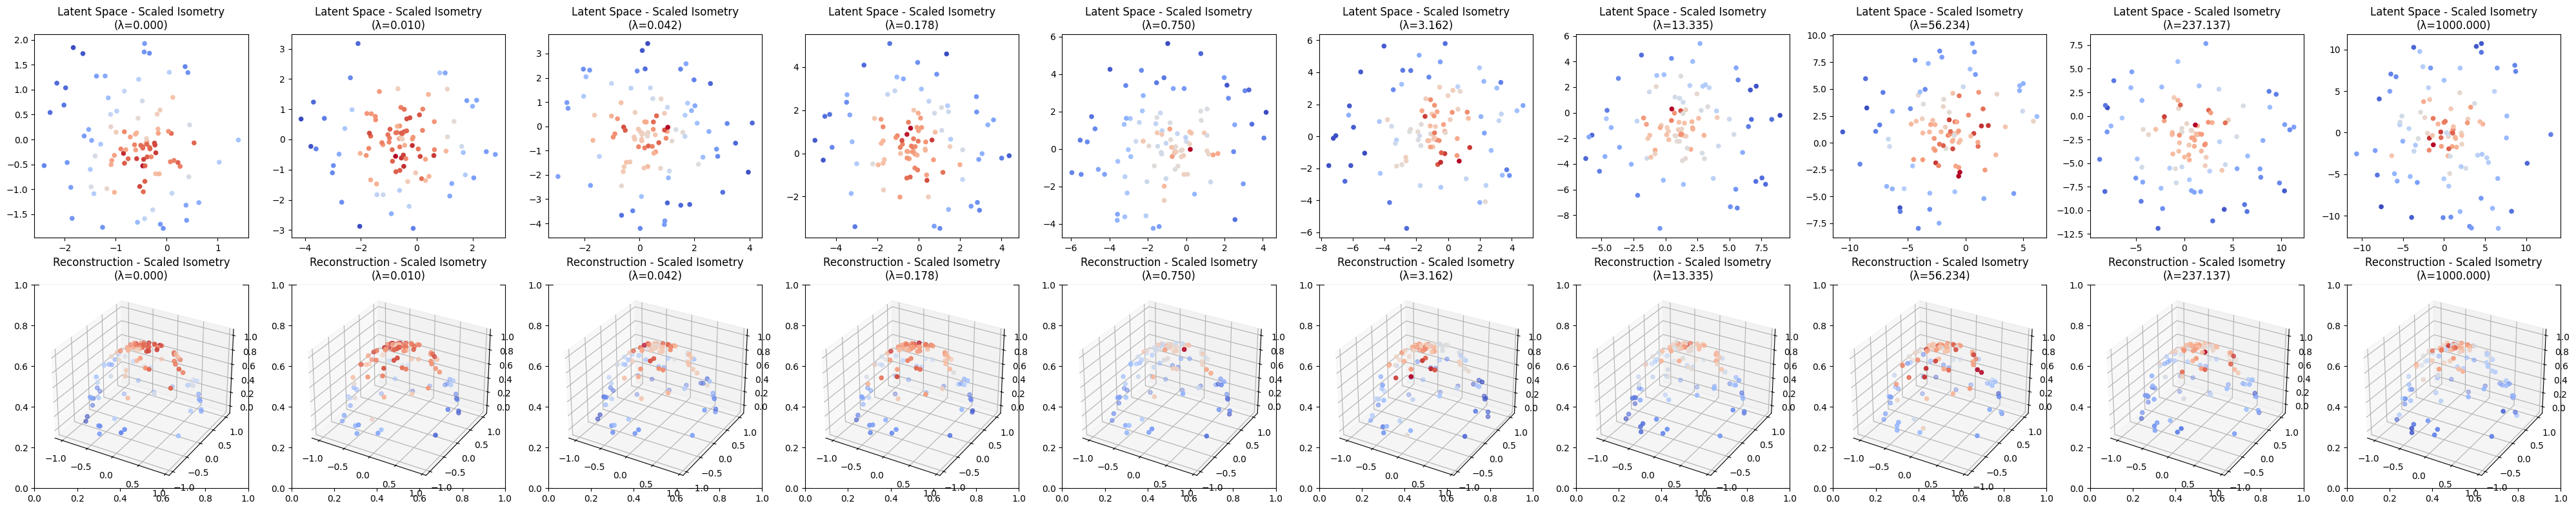

In [ ]:
# Analyze scaled isometry with trace visualization
fig, axs = plt.subplots(2, min(10, len(lambda_isos)), figsize=(4*min(10, len(lambda_isos)), 8))
if len(lambda_isos) == 1:
    axs = axs.reshape(2, 1)

for i, lambda_iso in enumerate(lambda_isos[:10]):  # Limit to 10 for visibility
    # Load model
    model_path = modelpath(dir_path, lambda_iso, 0)
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ScaledIsometricAutoencoder(encoder, decoder, lambda_iso=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    # Compute scaled isometry traces
    trace_vals = np.zeros_like(encoded_data[:, 0].cpu())
    for j, z in enumerate(encoded_data[:100]):  # Limit for computational efficiency
        z = z.unsqueeze(0)  # Add batch dimension
        
        # Compute the Jacobian J of the decoder at point z
        J = torch.autograd.functional.jacobian(model.decode, z)[0, :, 0, :]
        
        # Compute the trace of J^T J
        JtJ = J.T @ J
        trace_JtJ = torch.trace(JtJ)
        
        # Store the normalized trace value
        trace_vals[j] = trace_JtJ.item() / JtJ.shape[0]

    # Plot latent space colored by scaled isometry
    scatter = axs[0, i].scatter(encoded_data[:100, 0].cpu(), encoded_data[:100, 1].cpu(), 
                               c=trace_vals[:100], s=20, cmap='coolwarm')
    axs[0, i].set_title(f'Latent Space - Scaled Isometry\n(λ={lambda_iso:.3f})')
    
    # Plot reconstruction colored by scaled isometry
    ax_3d = fig.add_subplot(2, min(10, len(lambda_isos)), min(10, len(lambda_isos)) + i + 1, projection='3d')
    scatter_3d = ax_3d.scatter(reconstruction[:100, 0].cpu(), reconstruction[:100, 1].cpu(), 
                              reconstruction[:100, 2].cpu(), c=trace_vals[:100], s=20, cmap='coolwarm')
    ax_3d.set_title(f'Reconstruction - Scaled Isometry\n(λ={lambda_iso:.3f})')

plt.tight_layout()
plt.show()

In [14]:
# Comprehensive conformality evaluation (to compare with conformal autoencoders)
statses = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 0)
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ScaledIsometricAutoencoder(encoder, decoder, lambda_iso=lambda_iso).to(device)
    model.load_model_from_checkpoint(model_path)
    
    model.eval()
    stats = evaluate_conformality(model, val_data, double_precision=True)
    statses.append(stats)
    print(f"Lambda {lambda_iso:.3f} - Lambda mean: {stats['lambda_mean']:.4f}, std: {stats['lambda_std']:.4f}")

# Create comprehensive results DataFrame
df = pd.DataFrame(statses, index=[f"{λ:.3f}" for λ in lambda_isos])
print("\nConformality Analysis Complete (for scaled isometric autoencoder)")

Model and custom variables loaded from models/isometric_scaled_autoencoder_comp_scurve/lambda_0.000_model_1.pth
Lambda 0.000 - Lambda mean: 0.9452, std: 0.3364
Model and custom variables loaded from models/isometric_scaled_autoencoder_comp_scurve/lambda_0.001_model_1.pth
Lambda 0.001 - Lambda mean: 1.7306, std: 0.4659
Model and custom variables loaded from models/isometric_scaled_autoencoder_comp_scurve/lambda_0.004_model_1.pth
Lambda 0.004 - Lambda mean: 1.6784, std: 0.4075
Model and custom variables loaded from models/isometric_scaled_autoencoder_comp_scurve/lambda_0.018_model_1.pth
Lambda 0.018 - Lambda mean: 1.7372, std: 0.3779
Model and custom variables loaded from models/isometric_scaled_autoencoder_comp_scurve/lambda_0.075_model_1.pth
Lambda 0.075 - Lambda mean: 1.7713, std: 0.2500
Model and custom variables loaded from models/isometric_scaled_autoencoder_comp_scurve/lambda_0.316_model_1.pth
Lambda 0.316 - Lambda mean: 2.2510, std: 0.1149
Model and custom variables loaded from m

In [15]:
# Style the results DataFrame for better visualization
styled_df = df.style \
    .background_gradient(subset=[
            'reconstruction_error',
            'diagonal_gini',
            'lambda_std',
            'lambda_std_normed',
            'off_diag_mean',
            'off_diag_norm',
            'off_diag_mean_normed',
            'off_diag_norm_normed',
            'jTj_minus_lambdaI_mean',
            'jTj_minus_lambdaI_norm',
            'jTj_minus_lambdaI_mean_normed',
            'jTj_minus_lambdaI_norm_normed',
            'determinant_vs_estimate_std',
            ], cmap='Reds') \
    .background_gradient(subset=[
        'determinant_vs_estimate_mean'
    ], cmap='Greens') \
    .background_gradient(subset=[
        'lambda_mean',
        'latent_std',
        'latent_std_max',
        'latent_std_min',
        'latent_norm',
    ], cmap='Blues') \
    .format(precision=4)

styled_df